In [1]:
from ddnn.nn import *
from ddnn.validation import *
from ddnn.data import *

estimator = Estimator(
    net=NeuralNetwork([
        LinearLayer((9, 128)),
        ActivationFunction("ReLU"),
        LinearLayer((128, 2)),
    ]),
    loss=LossFunction("MSE"),
    # optimizer=Optimizer("SGD", learning_rate=0.5, momentum_coefficient=0.5, l2_coefficient=0),
    optimizer=Optimizer("Adam", learning_rate=0.5, l2_coefficient=1e-3),
    batchsize=-1,
    initializer=Initializer("glorot_uniform"),
    seed=1239147219
)
early_stopping = None #2.4934976413737315
epochs = 500
# dataset_type = ("monk", 2)
dataset_type = "ML_cup"
log_every = 1
losses = ["MSE", "MEE"]

In [2]:
if isinstance(dataset_type, tuple):
    traindata = read_monks(dataset_type[1], "train")
    traindata = onehot_encoding(data=traindata)

    testdata = read_monks(dataset_type[1], "test")
    testdata = onehot_encoding(data=testdata)
else:
    traindata = read_ML_cup("train")
    traindata, testdata = train_valid_split(traindata)
    blindtest = read_ML_cup("test")

In [3]:
traindata.shape, testdata.shape

((1044, (9, 2)), (448, (9, 2)))

In [4]:
testlogger = Logger(estimator, losses=losses, training_set=traindata, validation_set=testdata, every=log_every)
if early_stopping is not None:
    teststopper = TrainingThresholdStopping(estimator, early_stopping)
    def callback(record):
        testlogger(record)
        teststopper(record)
else:
    def callback(record):
        testlogger(record)

In [5]:
estimator.train(traindata, callback=callback, n_epochs=epochs)

In [6]:
res = estimator.evaluate(losses=losses, dataset=traindata)
res

{'MSE': 2.9874305184282437, 'MEE': 1.3767884739386844}

In [7]:
res = estimator.evaluate(losses=losses, dataset=testdata)
res

{'MSE': 4.67350974719727, 'MEE': 1.6953771937269415}

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from ipywidgets import interact
import numpy as np

interactive(children=(Dropdown(description='loss', options=('MSE', 'MEE'), value='MSE'), Output()), _dom_class…

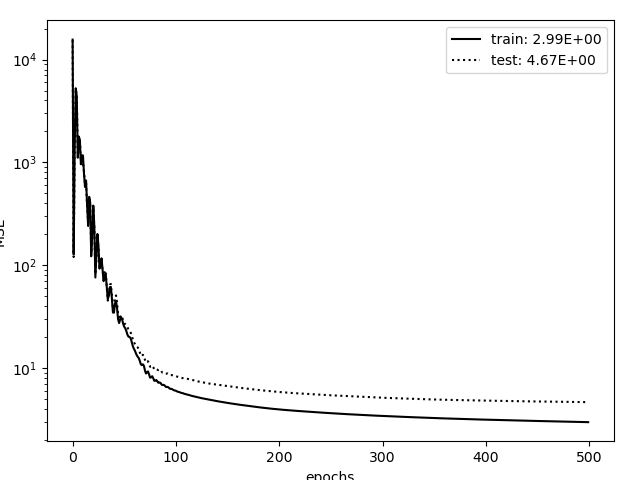

In [9]:
%matplotlib ipympl

# 1 plot with train and valid

fig, ax = plt.subplots()

@interact(
    loss = testlogger._losses,
)
def plot_results(loss):
    fig.tight_layout()
    ax.clear()
    ax.set_xlabel("epochs")
    ax.set_ylabel(loss)
    for where, style in zip(["train", "valid"], [None, "dotted"]):
        y = testlogger._scores[0]["folds"][0][where][loss]
        if loss == "binary_accuracy":
            # todo fix to show last not best
            best = max(y)
            form = "{:.2}"
            logplot = False
        else:
            best = min(y)
            form = "{:.2E}"
            logplot = True
        # scale to resemble number of epochs instead of plot points
        ticks_x = ticker.FuncFormatter(
            lambda x, pos: '{0:g}'.format(x*testlogger._every)
        )
        ax.xaxis.set_major_formatter(ticks_x)
        if logplot:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        if where == "valid": 
            where = "test"
        ax.plot(y, label=f"{where}: {form.format(best)}", 
            linestyle=style, color="black"
        )
        ax.legend()

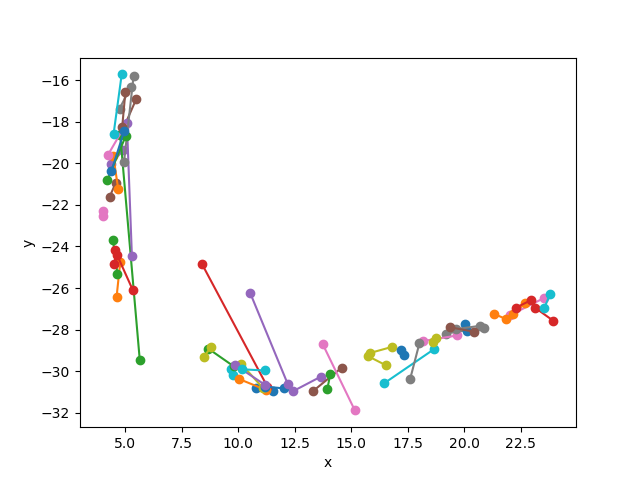

In [10]:
SAMPLE_SIZE = 50
sampleids = np.random.choice(
    np.arange(testdata.data.shape[0]), 
    size=SAMPLE_SIZE, replace=False
)
sampledata = testdata.data[sampleids]
samplepred = estimator.predict(sampledata)
samplelabels = testdata.labels[sampleids]

fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")

for i in range(samplelabels.shape[0]):
    ax.plot(
        [samplelabels[i, 0], samplepred[i, 0]], 
        [samplelabels[i, 1], samplepred[i, 1]],
        marker="o"
    )

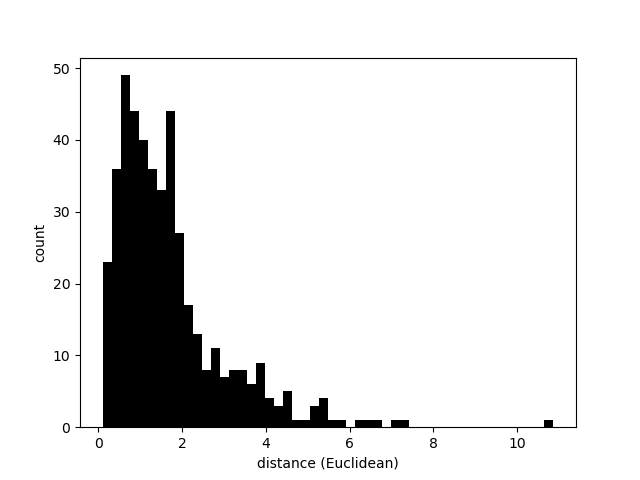

In [11]:
fig, ax = plt.subplots()

preds = estimator.predict(testdata)
labels = testdata.labels
distances = np.linalg.norm(preds - labels, axis=1, ord=2)

ax.set_xlabel("distance (Euclidean)")
ax.set_ylabel("count")
ax.hist(distances, bins=50, color="black");

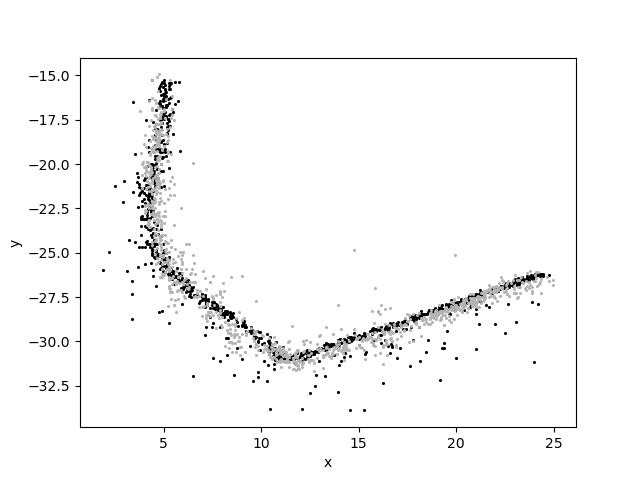

In [26]:
fig, ax = plt.subplots()

label = traindata.labels
pred = estimator.predict(traindata)

ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(label[:,0], label[:,1], color="black", s=6, marker=".")
ax.scatter(pred[:,0], pred[:,1], color=(0.7,0.7,0.7), s=6, marker=".");